### Introduction

This notebook contains an exercise where the task is to classify medical abstracts into one of the 23 categories.

- Data:
    - The data is compromised of the Ohsumed collection (available at ftp://medir.ohsu.edu/pub/ohsumed): it includes medical abstracts from the MeSH categories of the year 1991. In [Joachims, 1997] were used the first 20,000 documents divided in 10,000 for training and 10,000 for testing. The specific task was to categorize the 23 cardiovascular diseases categories. After selecting the such category subset, the unique abstract number becomes 13,929 (6,286 for training and 7,643 for testing). As current computers can easily manage larger number of documents we make available all 34,389 cardiovascular diseases abstracts out of 50,216 medical abstracts contained in the year 1991.
- Steps:
    - First i will start by constructing the dataframe of the Ohsumed collection
    - Since the data is in text format (string), i will be using TF-IDF to build up my features (there will be suggestions by the end of ways that could improve predictive power of the model)
    - Explore the distribution of all categories to check if there is risk of class imbalance
    - Choose dimension reduction technique using Chisquare of K-best features
    - construct model baseline using SVM and Logistic models 
    - Apply undersampling technique to tackle data imbalance
    - Discussion and suggestions
- Tools:
    - I use Python and different packages
    

In [1]:
# import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV

from collections import Counter

import re
import string 
import patoolib # pip install patool (data extraction)
import urllib 
import wget # pip install (download files)

#### Download and create the dataframe

In [2]:
path = 'F:\\morressier\\' #path where to download the file data

# check if path exists, otherwise create it
if not os.path.exists(path):
    os.makedirs(path)

file_compress_url = 'http://disi.unitn.it/moschitti/corpora/ohsumed-all-docs.tar.gz' #full url of file to download
file_description_url = 'http://disi.unitn.it/moschitti/corpora/First-Level-Categories-of-Cardiovascular-Disease.txt' #description

file_compress_name = os.path.split(file_compress_url)[-1]
file_description_name = os.path.split(file_description_url)[-1]

wget.download(file_compress_url,out=path_dl)
wget.download(file_description_url,out=path)
assert os.path.isfile(path+file_compress_name)
assert os.path.isfile(path+file_description_name)

100% [............................................................] 1334 / 1334

In [3]:
#read description file
tab = pd.read_csv(path+file_description_name,sep='\t',header=None)
tab.columns = ['text_line']
tab['topic'] = tab['text_line'].apply(lambda x: re.findall('(.*\S)\s+(C\d+)',x)[0][0])
tab['code'] = tab['text_line'].apply(lambda x: re.findall('(.*\S)\s+(C\d+)',x)[0][1])

In [4]:
# make a dictionary of topics with their codes ex: 'Bacterial Infections and Mycoses':'C01'
categories_dic = {}
for k,v in zip(tab['topic'],tab['code']):
    categories_dic[k] = v

#make an inverse dictionary
inverse_catdic = {v:k for k,v in categories_dic.items()}

categories_dic

{'Animal Diseases': 'C22',
 'Bacterial Infections and Mycoses': 'C01',
 'Cardiovascular Diseases': 'C14',
 'Digestive System Diseases': 'C06',
 'Disorders of Environmental Origin': 'C21',
 'Endocrine Diseases': 'C19',
 'Eye Diseases': 'C11',
 'Female Genital Diseases and Pregnancy Complications': 'C13',
 'Hemic and Lymphatic Diseases': 'C15',
 'Immunologic Diseases': 'C20',
 'Musculoskeletal Diseases': 'C05',
 'Neonatal Diseases and Abnormalities': 'C16',
 'Neoplasms': 'C04',
 'Nervous System Diseases': 'C10',
 'Nutritional and Metabolic Diseases': 'C18',
 'Otorhinolaryngologic Diseases': 'C09',
 'Parasitic Diseases': 'C03',
 'Pathological Conditions, Signs and Symptoms': 'C23',
 'Respiratory Tract Diseases': 'C08',
 'Skin and Connective Tissue Diseases': 'C17',
 'Stomatognathic Diseases': 'C07',
 'Urologic and Male Genital Diseases': 'C12',
 'Virus Diseases': 'C02'}

In [ ]:
# extract data within specificied file
patoolib.extract_archive(archive=path+file_compress_name, outdir= path)

In [5]:
# ensure the that the extracted files are those that we would expect
sub_files = []
for d in os.listdir(path):
    if d != 'ohsumed-all-docs.tar.gz' and os.path.isdir(path+d):
        sub_files.append(d)

filepath = ''
for f in sub_files:
    if os.listdir(path+f) == sorted(list(categories_dic.values())):
        filepath = os.path.join(path,f)
        print('full path to be use is : %s'%filepath)
        break
if filepath == '':
    print('no full path is assigned, check your paths')       

full path to be use is : F:\morressier\ohsumed-all


In [6]:
# collect files names for every category
files = os.listdir(filepath)

# count the number of all existing documents
count=0
for doc in files:
    count +=len(os.listdir(filepath+"\\"+doc))
count = [count]
print('There are %d documents in the collection'%count[0])

There are 56984 documents in the collection


In [7]:
# helper function to make dataframe
def make_dataframe(filepath,files):
    '''
    This function takes as input the file path, and all the 23 files that contain abstracts ex: "C01":[abstract01,abstract02...abstractN]
    then output a pandas dataframe that has two columns ['documents','categories'] with 56984 rows, and 23 unique classes
    '''
    assert isinstance(filepath, str)
    assert isinstance(files, list) 
    df = pd.DataFrame(columns=['documents','categories']) 
    for file in files: # iterrate over every file
        documentssample = os.listdir(os.path.join(filepath,file)) # get the list of names of every document within a file
        docs = [] #list of documents
        cat = [] #list of categories
        for doc in documentssample:
            f = open(os.path.join(filepath,file,doc)) #access document
            lines = [s.strip().lower() for s in f.readlines()] #read and split the document into lines
            l_bis = [] #list of cleaned lines
            for x in lines:
                tokens = []
                x = re.sub('['+string.punctuation+']','',x) #remove punctuation
                for y in x.split():
                    if y.isalpha():
                        tokens.append(y) # keep alpha characters only
                l_bis.append(' '.join(tokens)) # append clean lines
            para = ' '.join(l_bis) #create the final document
            docs.append(para) # append document to list of documents for given file
            cat.append(inverse_catdic[file]) # append respective categories
            f.close() 
        sample = pd.DataFrame(data=np.array((docs,cat),dtype='O').T,columns=['documents','categories']) # make dataframe sample of the file
        df = pd.concat([df,sample]) # concat the sample with the full dataframe
    assert df.shape[0] == count[0]
    assert (df['categories'].unique().shape[0]==len(files))
    return df

In [8]:
df = make_dataframe(filepath,files)
df.reset_index(drop=True, inplace=True)

In [9]:
df.head()

,documents,categories
0,haemophilus influenzae meningitis with prolong...,Bacterial Infections and Mycoses
1,augmentation mentoplasty using mersilene mesh ...,Bacterial Infections and Mycoses
2,multiple intracranial mucoceles associated wit...,Bacterial Infections and Mycoses
3,replacement of an aortic valve cusp after neon...,Bacterial Infections and Mycoses
4,mucosal intussusception to avoid ascending cho...,Bacterial Infections and Mycoses


In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56984 entries, 0 to 56983
Data columns (total 2 columns):
documents     56984 non-null object
categories    56984 non-null object
dtypes: object(2)
memory usage: 69.8 MB


#### Data exploration

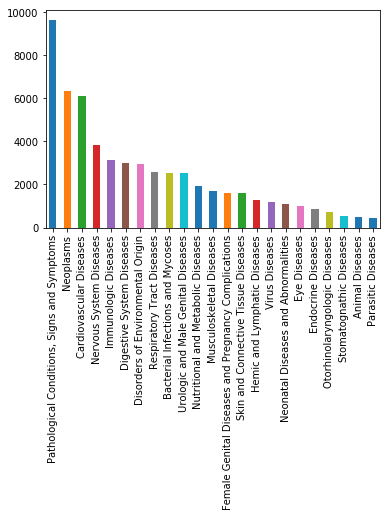

In [11]:
# class distribution
df['categories'].value_counts().plot(kind='bar')

In [12]:
# convert class name to numerical values for later processing
df['cat_categories'] = df['categories'].apply(lambda x: int(categories_dic[x].replace('C','')))

In [13]:
df.head()

,documents,categories,cat_categories
0,haemophilus influenzae meningitis with prolong...,Bacterial Infections and Mycoses,1
1,augmentation mentoplasty using mersilene mesh ...,Bacterial Infections and Mycoses,1
2,multiple intracranial mucoceles associated wit...,Bacterial Infections and Mycoses,1
3,replacement of an aortic valve cusp after neon...,Bacterial Infections and Mycoses,1
4,mucosal intussusception to avoid ascending cho...,Bacterial Infections and Mycoses,1


In [14]:
# prepare TF-IDF vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_features=75000,
                        norm='l2', encoding='latin-1', ngram_range=(1, 4),
                        stop_words='english')


In [15]:
# transform the data
features = tfidf.fit_transform(df.documents)
labels = df.cat_categories.values
features.shape

(56984, 75000)

In [16]:
# make two dictionnaries that will be helpful later: Category to id, and id to category
category_to_id = dict(df[['categories','cat_categories']].values)
id_to_category = dict(df[['cat_categories','categories']].values)

In [17]:
#explore top words that are correlating with every class
N = 2
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Animal Diseases':
  . Most correlated unigrams:
. model
. mdx
  . Most correlated bigrams:
. normal dystrophic
. animal model
# 'Bacterial Infections and Mycoses':
  . Most correlated unigrams:
. infections
. bacterial
  . Most correlated bigrams:
. haemophilus influenzae
. septic shock
# 'Cardiovascular Diseases':
  . Most correlated unigrams:
. myocardial
. coronary
  . Most correlated bigrams:
. left ventricular
. myocardial infarction
# 'Digestive System Diseases':
  . Most correlated unigrams:
. biliary
. cirrhosis
  . Most correlated bigrams:
. ulcerative colitis
. crohns disease
# 'Disorders of Environmental Origin':
  . Most correlated unigrams:
. fractures
. injuries
  . Most correlated bigrams:
. blunt trauma
. alcohol abuse
# 'Endocrine Diseases':
  . Most correlated unigrams:
. hypothyroidism
. thyroid
  . Most correlated bigrams:
. diabetic patients
. thyroid hormone
# 'Eye Diseases':
  . Most correlated unigrams:
. glaucoma
. eyes
  . Most correlated bigrams:
. visual 

### Model training

##### baseline model

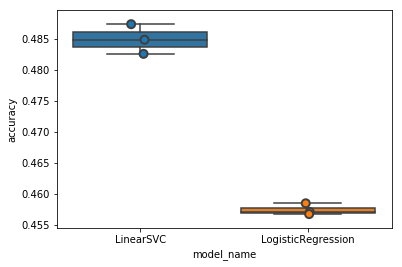

In [18]:
models = [
    LinearSVC(),
    LogisticRegression(),
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [19]:
pd.pivot_table(cv_df,index='model_name',values='accuracy') # LinearSVC outperforms the Logistic

,accuracy
model_name,
LinearSVC,0.484960
LogisticRegression,0.457392


##### Features selection

I will be using Chi-square to select the k-best features that correlate with target data

In [20]:
feat_dic = {}
for i in range(2,21):
    test = SelectKBest(score_func=chi2, k=features.shape[1]//i)
    fit_ = test.fit(features, labels)
    features_ = fit_.transform(features)
    CV = 3
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features_, labels, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    feat_dic[i] = entries
    print('Training for {} k-best features is done'.format(features_.shape[1]))

Training for 37500 k-best features is done
Training for 25000 k-best features is done
Training for 18750 k-best features is done
Training for 15000 k-best features is done
Training for 12500 k-best features is done
Training for 10714 k-best features is done
Training for 9375 k-best features is done
Training for 8333 k-best features is done
Training for 7500 k-best features is done
Training for 6818 k-best features is done
Training for 6250 k-best features is done
Training for 5769 k-best features is done
Training for 5357 k-best features is done
Training for 5000 k-best features is done
Training for 4687 k-best features is done
Training for 4411 k-best features is done
Training for 4166 k-best features is done
Training for 3947 k-best features is done
Training for 3750 k-best features is done


In [21]:
#make dataframe of accuracies for every iteration of every model and every fold
list_accuracies = []
for i,k in feat_dic.items():
    list_accuracies.extend([x[-1] for x in k])

idx = pd.IndexSlice
indices = pd.MultiIndex.from_product([list(range(2,21)),['SVC','logistic'],['cv1','cv2','cv3']])
accuracies = pd.DataFrame(list_accuracies,indices, columns=['accuracy'])
accuracies.index.names = ['kbest_factor','model','fold']    

In [22]:
accuracies.head(15)

accuracy
kbest_factor model    fold          
2            SVC      cv1   0.489765
                      cv2   0.486654
                      cv3   0.488307
             logistic cv1   0.459454
                      cv2   0.460068
                      cv3   0.461182
3            SVC      cv1   0.492606
                      cv2   0.490866
                      cv3   0.493469
             logistic cv1   0.457875
                      cv2   0.459753
                      cv3   0.461393
4            SVC      cv1   0.493869
                      cv2   0.493393
                      cv3   0.495207

In [23]:
pd.pivot_table(accuracies,index='model',values='accuracy',aggfunc=['mean','std'])

,mean,std
,accuracy,accuracy
model,,
SVC,0.494106,0.002822
logistic,0.449135,0.007530


In [24]:
n = range(2,21)

mean_svc =accuracies.loc[idx[:,'SVC'],].mean(level='kbest_factor')
std_svc = accuracies.loc[idx[:,'SVC'],].std(level='kbest_factor')

mean_log = accuracies.loc[idx[:,'logistic'],].mean(level='kbest_factor')
std_log = accuracies.loc[idx[:,'logistic'],].std(level='kbest_factor')


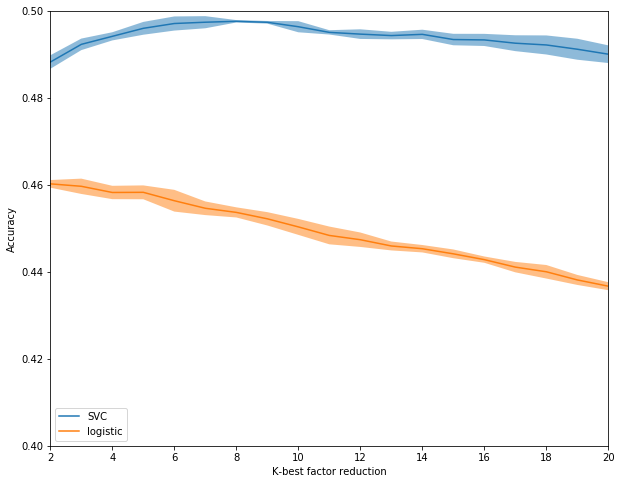

In [25]:
# plot accuracies with their standard deviations
plt.subplots(figsize=(10,8))
plt.plot(n,mean_svc,label='SVC')
plt.fill_between(n,mean_svc['accuracy']+std_svc['accuracy'],mean_svc['accuracy']-std_svc['accuracy'],alpha=0.5)
plt.plot(n,mean_log,label='logistic')
plt.fill_between(n,mean_log['accuracy']+std_log['accuracy'],mean_log['accuracy']-std_log['accuracy'],alpha=0.5)
plt.ylim([0.4,0.5])
plt.xlim([2,20])
plt.ylabel('Accuracy')
plt.xlabel('K-best factor reduction')
plt.legend()

In [26]:
pd.pivot_table(accuracies.loc[idx[:,'SVC'],],index='kbest_factor',aggfunc=['mean','std']).sort_values(by=[('std','accuracy'),('mean','accuracy')],ascending=True)[:5]

,mean,std
,accuracy,accuracy
kbest_factor,,
8,0.497613,0.000276
9,0.497385,0.000304
11,0.495069,0.000498
13,0.494332,0.000863
4,0.494156,0.000940


K_factor of 8 results in high performance and low std in the cross validation. We will use k_factor = 8 to choose 9375 k-best features.

Next we will train the model using two ways:

    1 - Split the data and train it as it is 
    2 - split the data and train it using undersampling 

in each approach we will test the trained model on the whole data

#### 1: without undersampling the data

In [27]:
k_factor = 8
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=0,stratify=labels)
test = SelectKBest(score_func=chi2, k=features.shape[1]//k_factor)
fit_ = test.fit(features, labels)
X_train = fit_.transform(X_train)
X_test  = fit_.transform(X_test)

model = LinearSVC()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

Text(0.5,114,'Predicted')

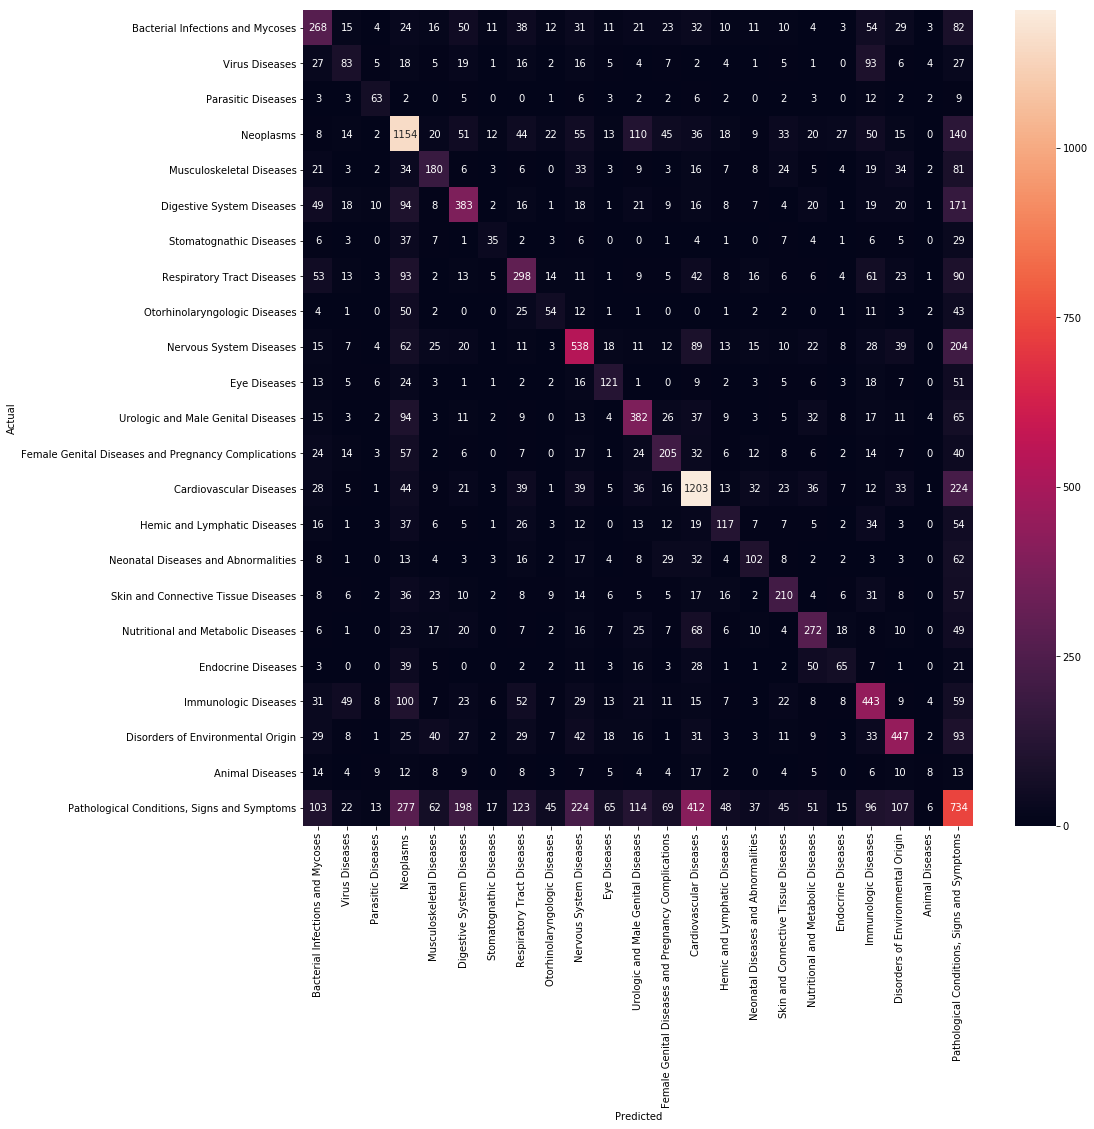

In [28]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
ticks = [x[1] for x in sorted(inverse_catdic.items())]
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [29]:
print(classification_report(y_test, y_pred,target_names=ticks))

                                                     precision    recall  f1-score   support

                   Bacterial Infections and Mycoses       0.36      0.35      0.35       762
                                     Virus Diseases       0.30      0.24      0.26       351
                                 Parasitic Diseases       0.45      0.49      0.47       128
                                          Neoplasms       0.49      0.61      0.54      1898
                           Musculoskeletal Diseases       0.40      0.36      0.38       503
                          Digestive System Diseases       0.43      0.43      0.43       897
                            Stomatognathic Diseases       0.33      0.22      0.26       158
                         Respiratory Tract Diseases       0.38      0.38      0.38       777
                      Otorhinolaryngologic Diseases       0.28      0.25      0.26       215
                            Nervous System Diseases       0.45      0

In [30]:
print(classification_report(labels, model.predict(fit_.transform(features)),target_names=ticks))

                                                     precision    recall  f1-score   support

                   Bacterial Infections and Mycoses       0.50      0.51      0.51      2540
                                     Virus Diseases       0.50      0.39      0.44      1171
                                 Parasitic Diseases       0.62      0.70      0.66       427
                                          Neoplasms       0.57      0.70      0.63      6327
                           Musculoskeletal Diseases       0.53      0.48      0.51      1678
                          Digestive System Diseases       0.53      0.56      0.55      2989
                            Stomatognathic Diseases       0.54      0.44      0.48       526
                         Respiratory Tract Diseases       0.50      0.50      0.50      2589
                      Otorhinolaryngologic Diseases       0.51      0.47      0.49       715
                            Nervous System Diseases       0.55      0

There performance on the test data is close the performance of the cross-validation, however, when we predict on the full dataset, the model shows performance over 53% (precision, recall and f1 score) and which could suggest overfitting. One unexpected behavior was related to class imbalance, in fact, the majority class shows lower performance in recall than the minority class, which suggests a further investigation about the features of majority class. next we will proceed to train the model using undersampling, then, oversampling the minority class. this method will lead to increase recall performance of minority class.

#### 2: undersampling the data

In [31]:
count_cat_train = sorted(Counter([x for x in y_train]).items(), key=lambda x: x[1])

In [32]:
min_cat_value = count_cat_train[0][1]
catmin_ind = (y_train == count_cat_train[0][0]).nonzero()
full_ind = catmin_ind[0]
for i in range(1,23):
    catmaj_ind = (y_train == count_cat_train[i][0]).nonzero()

    catmaj_sampled_ind = np.random.choice(catmaj_ind[0], min_cat_value, replace=False)
    full_ind = np.hstack((full_ind,catmaj_sampled_ind))
    np.random.shuffle(full_ind)
    
    
sampled_data = X_train[full_ind]
sampled_labels = y_train[full_ind]

model = LinearSVC(C=0.5)

calibrated_svc = CalibratedClassifierCV(model,
                                        method='sigmoid', 
                                        cv=2) 
calibrated_svc.fit(sampled_data,sampled_labels)
sampled_y_pred = calibrated_svc.predict(sampled_data)

In [33]:
print(classification_report(sampled_labels,sampled_y_pred))

             precision    recall  f1-score   support

          1       0.69      0.65      0.67       299
          2       0.74      0.70      0.72       299
          3       0.88      0.92      0.90       299
          4       0.66      0.65      0.66       299
          5       0.72      0.75      0.73       299
          6       0.72      0.82      0.77       299
          7       0.80      0.88      0.84       299
          8       0.67      0.66      0.66       299
          9       0.78      0.85      0.81       299
         10       0.65      0.74      0.69       299
         11       0.80      0.77      0.78       299
         12       0.70      0.80      0.75       299
         13       0.72      0.76      0.74       299
         14       0.70      0.77      0.73       299
         15       0.73      0.80      0.76       299
         16       0.77      0.82      0.79       299
         17       0.78      0.83      0.80       299
         18       0.80      0.73      0.76   

In [34]:
# make prediction on X_test without applying undersampling
print(classification_report(y_test,calibrated_svc.predict(X_test)))

             precision    recall  f1-score   support

          1       0.41      0.37      0.39       762
          2       0.24      0.42      0.31       351
          3       0.40      0.77      0.52       128
          4       0.59      0.40      0.47      1898
          5       0.33      0.47      0.39       503
          6       0.44      0.58      0.50       897
          7       0.30      0.69      0.42       158
          8       0.40      0.46      0.43       777
          9       0.33      0.76      0.46       215
         10       0.44      0.48      0.46      1155
         11       0.42      0.67      0.52       299
         12       0.46      0.61      0.52       755
         13       0.43      0.62      0.50       487
         14       0.60      0.58      0.59      1831
         15       0.28      0.52      0.37       383
         16       0.29      0.56      0.38       326
         17       0.41      0.54      0.46       485
         18       0.49      0.51      0.50   

Text(0.5,114,'Predicted')

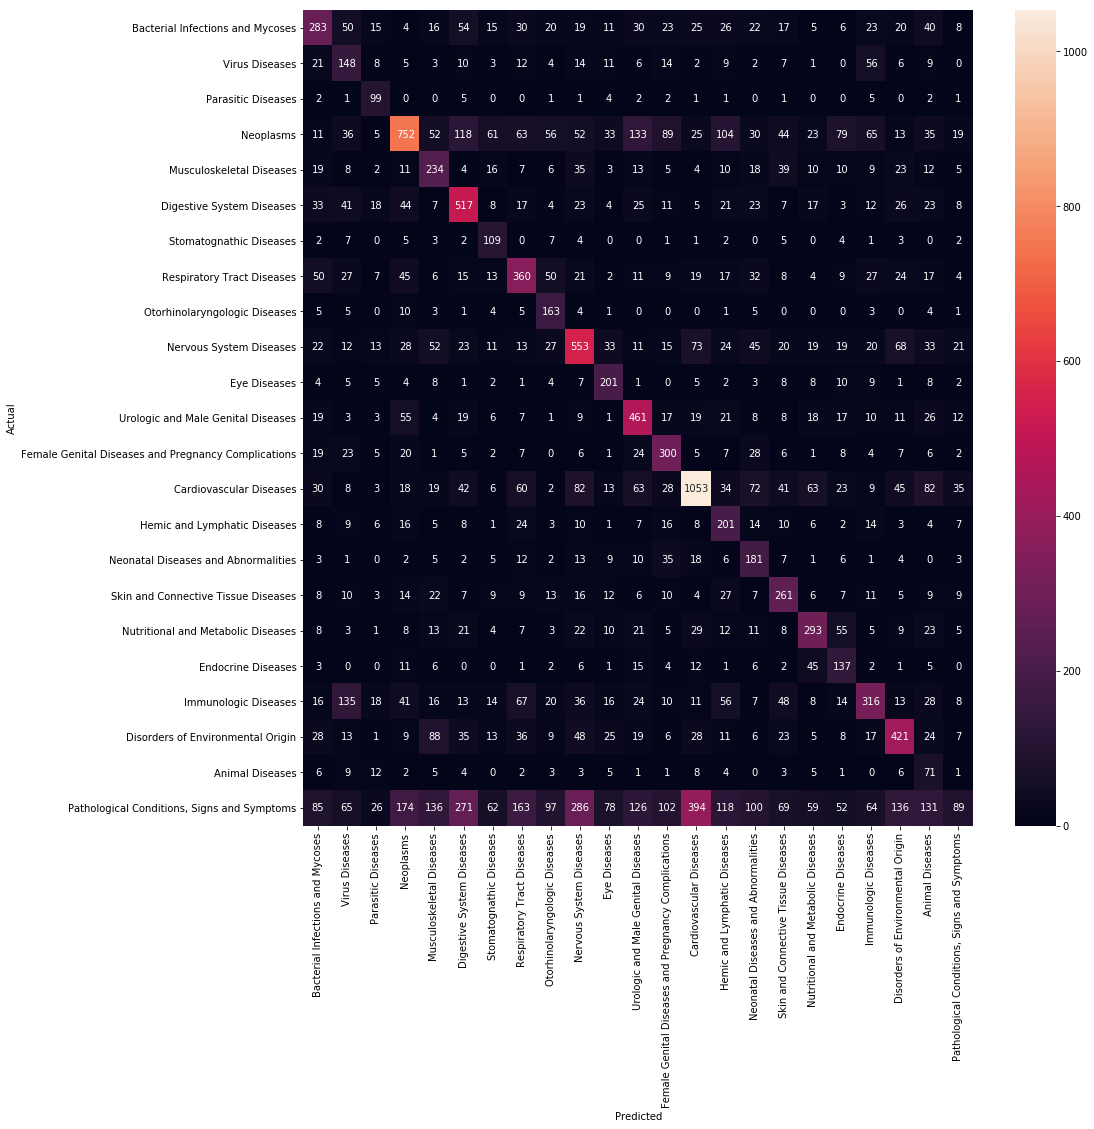

In [35]:
conf_mat = confusion_matrix(y_test,calibrated_svc.predict(X_test))
fig, ax = plt.subplots(figsize=(15,15))
ticks = [x[1] for x in sorted(inverse_catdic.items())]
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [36]:
count_cat_test =  sorted(Counter([x for x in y_test]).items(), key=lambda x: x[1])

In [37]:
# apply undersampling on X_test then proceed to make predictions
min_cat_value = count_cat_test[0][1]
catmin_ind = (y_test == count_cat_test[0][0]).nonzero()
full_ind_test = catmin_ind[0]
for i in range(1,23):
    catmaj_ind = (y_test == count_cat_test[i][0]).nonzero()

    catmaj_sampled_ind = np.random.choice(catmaj_ind[0], min_cat_value, replace=False)
    full_ind_test = np.hstack((full_ind_test,catmaj_sampled_ind))
    np.random.shuffle(full_ind_test)
    
    
sampled_data_test = X_test[full_ind_test]
sampled_labels_test = y_test[full_ind_test]

sampled_y_pred_test = calibrated_svc.predict(sampled_data_test)

In [38]:
print(classification_report(sampled_labels_test,sampled_y_pred_test))

             precision    recall  f1-score   support

          1       0.41      0.34      0.37       128
          2       0.34      0.39      0.37       128
          3       0.76      0.77      0.77       128
          4       0.40      0.44      0.42       128
          5       0.46      0.42      0.44       128
          6       0.50      0.58      0.54       128
          7       0.74      0.70      0.71       128
          8       0.42      0.42      0.42       128
          9       0.67      0.77      0.71       128
         10       0.37      0.47      0.41       128
         11       0.69      0.68      0.68       128
         12       0.49      0.62      0.55       128
         13       0.56      0.59      0.58       128
         14       0.45      0.51      0.47       128
         15       0.47      0.51      0.49       128
         16       0.56      0.59      0.58       128
         17       0.56      0.56      0.56       128
         18       0.53      0.49      0.51   

Even if we see increase in performance, this prediction is just over one sample of the test set. in order to make a better generalization we need to undersample the test set over the minority class and for all other classes of the test set.

In [39]:
sampled_test_test = SelectKBest(score_func=chi2, k=X_test.shape[1]//k_factor)
sampled_fit_test = test.fit(X_test, y_test)
predictions = {}
min_cat_value = count_cat_test[0][1]
catmin_ind = (y_test == count_cat_test[0][0]).nonzero()[0]
for j in range(1,23):
    l =(y_test == count_cat_test[j][0]).nonzero()[0].shape[0]
    for x in range(round(l/min_cat_value)+1):
        r_test = (y_test == count_cat_test[j][0]).nonzero()[0][x*(min_cat_value):(x+1)*(min_cat_value)]
        l_r_test = len(r_test)
        if l_r_test<min_cat_value and l_r_test>0:
            #print(l_r_test)
            r_test_new = np.hstack((r_test,np.random.choice((y_test == count_cat_test[j][0]).nonzero()[0][0:(x)*min_cat_value],min_cat_value-l_r_test)))
            #print(r_test_new.shape[0])
            r_test_new = np.hstack((r_test_new,catmin_ind))
        elif l_r_test==min_cat_value:
            #print(l_r_test)
            r_test_new = np.hstack((r_test,catmin_ind))
          

        else:
            continue
        np.random.shuffle(r_test_new)
        full_ind_test = r_test_new.copy()  
        rng = list(range(1,23))
        rng.remove(j)
        for i in rng:
            catmaj_ind = (y_test == count_cat_test[i][0]).nonzero()

            catmaj_sampled_ind = np.random.choice(catmaj_ind[0], min_cat_value, replace=False)
            full_ind_test = np.hstack((full_ind_test,catmaj_sampled_ind))
            np.random.shuffle(full_ind_test)


        sampled_data_test = X_test[full_ind_test]
        sampled_labels_test = y_test[full_ind_test]

        sampled_features_test = fit_.transform(sampled_data_test)

        sampled_y_predictions_test = calibrated_svc.predict(sampled_features_test)
        for ixx,v in zip(full_ind_test,sampled_y_predictions_test):
            if ixx in predictions:
                predictions[ixx].append(v)
            else:
                predictions[ixx] = [v]

In [40]:
arr = []
count = 0
for k,v in predictions.items():
    arr.append(Counter(v).most_common()[0][0])

In [41]:
print(classification_report(y_test,arr))

             precision    recall  f1-score   support

          1       0.41      0.37      0.39       762
          2       0.24      0.42      0.31       351
          3       0.40      0.77      0.52       128
          4       0.59      0.40      0.47      1898
          5       0.33      0.47      0.39       503
          6       0.44      0.58      0.50       897
          7       0.30      0.69      0.42       158
          8       0.40      0.46      0.43       777
          9       0.33      0.76      0.46       215
         10       0.44      0.48      0.46      1155
         11       0.42      0.67      0.52       299
         12       0.46      0.61      0.52       755
         13       0.43      0.62      0.50       487
         14       0.60      0.58      0.59      1831
         15       0.28      0.52      0.37       383
         16       0.29      0.56      0.38       326
         17       0.41      0.54      0.46       485
         18       0.49      0.51      0.50   

Text(0.5,114,'Predicted')

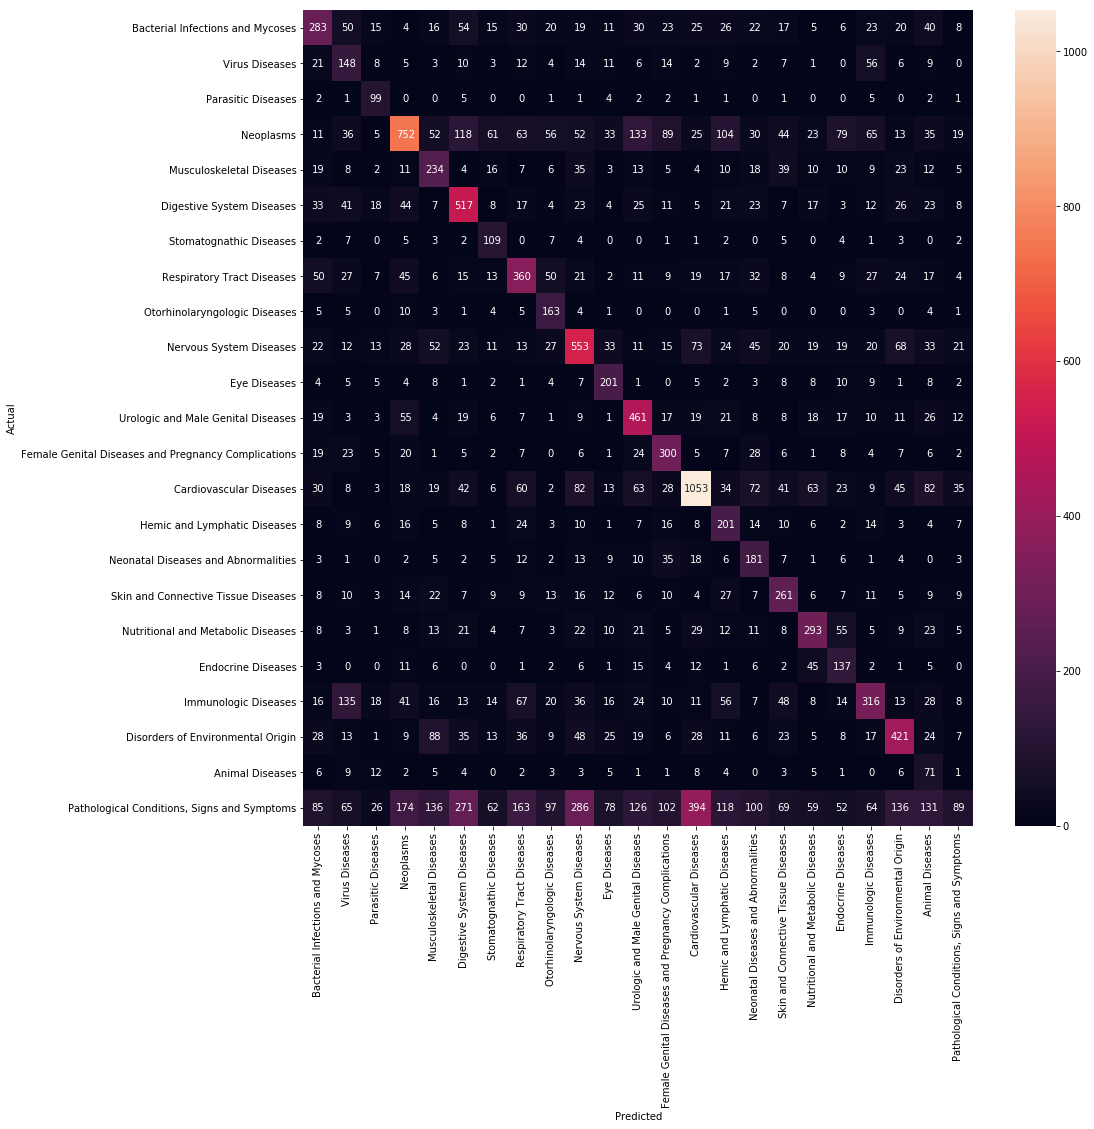

In [42]:
conf_mat = confusion_matrix(y_test,arr)
fig, ax = plt.subplots(figsize=(15,15))
ticks = [x[1] for x in sorted(inverse_catdic.items())]
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [43]:
count_cat_full =  sorted(Counter([x for x in labels]).items(), key=lambda x: x[1])
sampled_test_full = SelectKBest(score_func=chi2, k=features.shape[1]//k_factor)
sampled_fit_full = test.fit(features, labels)
predictions_full = {}
min_cat_value = count_cat_full[0][1]
catmin_ind = (labels == count_cat_full[0][0]).nonzero()[0]
for j in range(1,23):
    l =(labels == count_cat_full[j][0]).nonzero()[0].shape[0]
    for x in range(round(l/min_cat_value)+1):
        r_test = (labels == count_cat_full[j][0]).nonzero()[0][x*(min_cat_value):(x+1)*(min_cat_value)]
        l_r_test = len(r_test)
        if l_r_test<min_cat_value and l_r_test>0:
            #print(l_r_test)
            r_test_new = np.hstack((r_test,np.random.choice((labels == count_cat_full[j][0]).nonzero()[0][0:(x)*min_cat_value],min_cat_value-l_r_test)))
            #print(r_test_new.shape[0])
            r_test_new = np.hstack((r_test_new,catmin_ind))
        elif l_r_test==min_cat_value:
            #print(l_r_test)
            r_test_new = np.hstack((r_test,catmin_ind))
          

        else:
            continue
        np.random.shuffle(r_test_new)
        full_ind_full = r_test_new.copy()  
        rng = list(range(1,23))
        rng.remove(j)
        for i in rng:
            catmaj_ind = (labels == count_cat_full[i][0]).nonzero()

            catmaj_sampled_ind = np.random.choice(catmaj_ind[0], min_cat_value, replace=False)
            full_ind_full = np.hstack((full_ind_full,catmaj_sampled_ind))
            np.random.shuffle(full_ind_full)


        sampled_data_full = features[full_ind_full]
        sampled_labels_full = labels[full_ind_full]

        sampled_features_full = fit_.transform(sampled_data_full)

        sampled_y_predictions_full = calibrated_svc.predict(sampled_features_full)
        for ixx,v in zip(full_ind_full,sampled_y_predictions_full):
            if ixx in predictions_full:
                predictions_full[ixx].append(v)
            else:
                predictions_full[ixx] = [v]

In [44]:
arr_full = []
count = 0
for k,v in predictions_full.items():
    arr_full.append(Counter(v).most_common()[0][0])

In [45]:
print(classification_report(labels,arr_full,target_names=ticks))

                                                     precision    recall  f1-score   support

                   Bacterial Infections and Mycoses       0.45      0.40      0.42      2540
                                     Virus Diseases       0.31      0.51      0.38      1171
                                 Parasitic Diseases       0.46      0.87      0.60       427
                                          Neoplasms       0.62      0.41      0.50      6327
                           Musculoskeletal Diseases       0.36      0.51      0.42      1678
                          Digestive System Diseases       0.45      0.59      0.51      2989
                            Stomatognathic Diseases       0.31      0.81      0.45       526
                         Respiratory Tract Diseases       0.42      0.48      0.45      2589
                      Otorhinolaryngologic Diseases       0.35      0.78      0.48       715
                            Nervous System Diseases       0.44      0

Text(0.5,114,'Predicted')

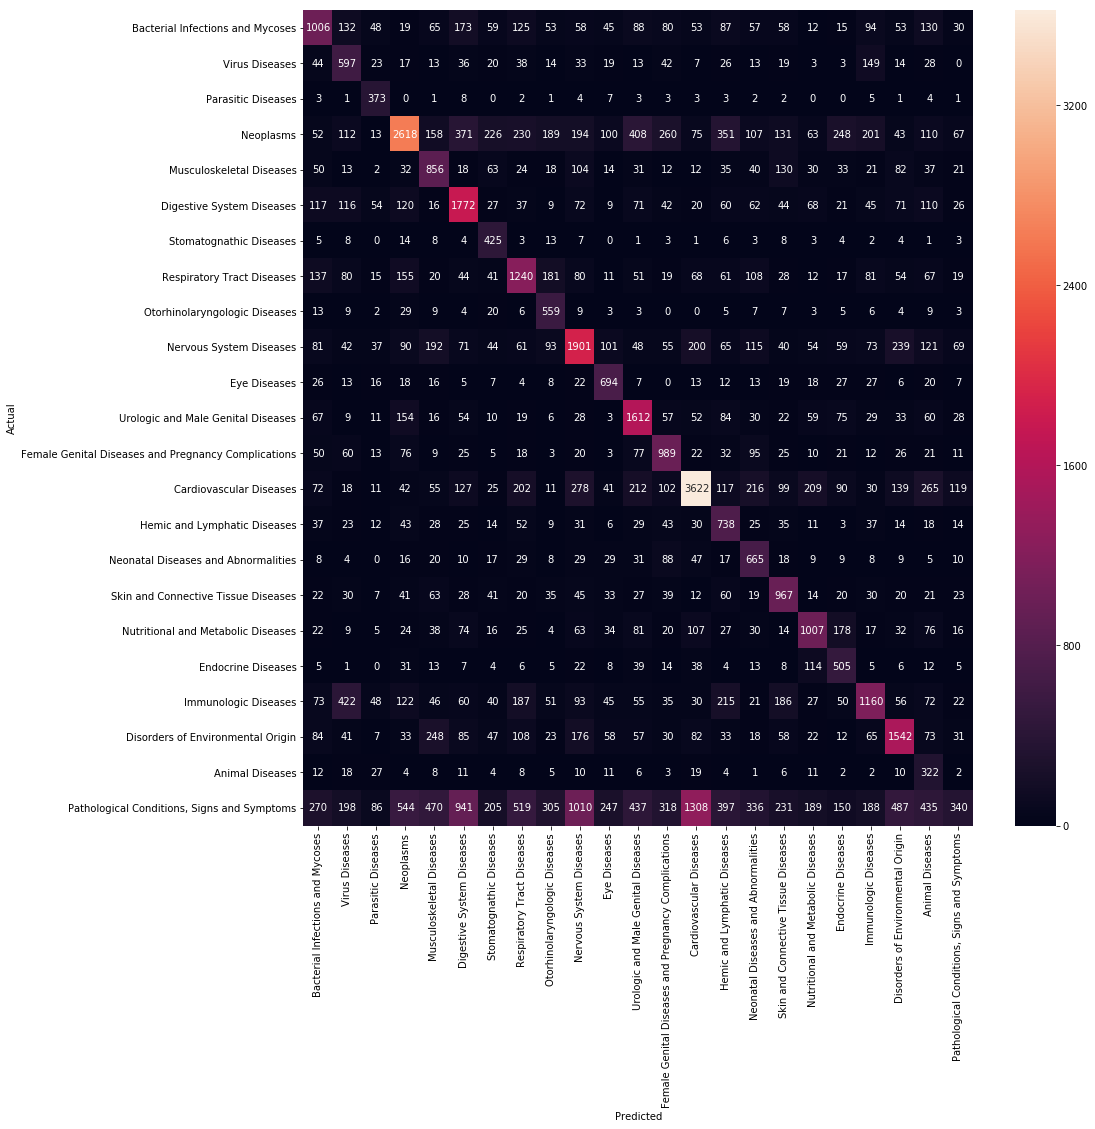

In [46]:
conf_mat = confusion_matrix(labels,arr_full)
fig, ax = plt.subplots(figsize=(15,15))
ticks = [x[1] for x in sorted(inverse_catdic.items())]
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Discussion

This study case was an example of multiclass imbalanced data. The choice of features building was TF-IDF and it was mainly motived by local computational limitations. Next, we went to select best features using Chi-square technique, and finally trained the model wihtout and with undersampling. The overall performance was close to the baseline as expected. However we observed that we had a positive improvement in performance in regards to minority class (70% recall score on baseline and 86% on undersampled model), while we saw a decrease in performance in regards to majority class (36% recall score on baseline and 5% on undersampled model). 

We could investigate the situation even more and try other approaches such as:

- use words embedding rather than TF-IDF
- use LDA or LSA for feature selection, and explore autocorrelation 
- Incorporate other features such as: sentiment score, lexical diversity, or sub-topics (using LDA)
- using other algorithms (trees, adaboost or NN)
- use of LSTM with NN
- using different layers with ensemble models
- use oversampling instead of undersampling